# Econometric Project


Clément ABISSI 
\
Théo BOLTZ
\
Ulysse GRIMAULT
\
Mickael TEBOUL

## Introduction

The objective of this notebook is to forecast the NIFTY 50 index using both univariate and multivariate models (with exogenous variables), in order to build a trading algorithm and analyze its performance.

## Librairies

In [237]:
import matplotlib.pyplot as plt
import datetime
import yfinance as yf  #need the last version of yfinance to avoid "limit exceeded" error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import warnings
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import ccf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from tqdm import tqdm
import random

sns.set(style="whitegrid")
np.random.seed(42)
warnings.filterwarnings("ignore")

## DataSet

 We download historical prices for the Nifty 50 (India) and Nikkei 225 (Japan) indices using yfinance. The data is cleaned and aligned so both indices share the same dates.

In [292]:
#import of the Nifty 50 index
nifty = yf.Ticker("^NSEI")
nifty_0 = nifty.history(period="7y").loc[:'2025-06-10'] #We take values until we have for the vix
nifty = nifty_0["Close"]

# import of the Nikkei 225 index
nikkei = yf.Ticker("^N225")
nikkei_0 = nikkei.history(period="7y").loc[:'2025-06-10']
nikkei = nikkei_0["Close"]

In [293]:
# import of the india Vix
vix_nifty_0 = pd.read_csv("vix_INDIA.csv", index_col=0, parse_dates=True)
vix_nifty_0 = vix_nifty_0.iloc[:-1] #We have a Nan and values only until 10

In [294]:
# Ensure both indices have datetime indexes without timezone information
nifty_0.index = pd.to_datetime(nifty_0.index).tz_localize(None)
nikkei_0.index = pd.to_datetime(nikkei_0.index).tz_localize(None)
vix_nifty_0.index = pd.to_datetime(vix_nifty_0.index).tz_localize(None)
# Create a common date index 
combined_dates = nifty_0.index.union(nikkei_0.index)

# Reindex both DataFrames on the common dates and fill with backward fill
nifty_0 = nifty_0.reindex(combined_dates).bfill()
nikkei_0 = nikkei_0.reindex(combined_dates).bfill()
vix_nifty_0 = vix_nifty_0.reindex(combined_dates).bfill()
# Calculate the difference between Open and Previous Close for Nifty 
nikkei_0['Prev_Close'] = nikkei_0['Close'].shift(1)  
nikkei_0['Diff'] = nikkei_0['Open'] - nikkei_0['Prev_Close']

We set up our features and target : 
- `X` is the Nikkei open-close difference.
- `y` is the Nifty 50 close price (our target).

We split the data into a small training set and a large test set, without shuffling, to preserve the chronological order essential for time series analysis. Only 20% of the data is used for training, as we require a large test set to evaluate the performance of our forecasting and trading algorithms


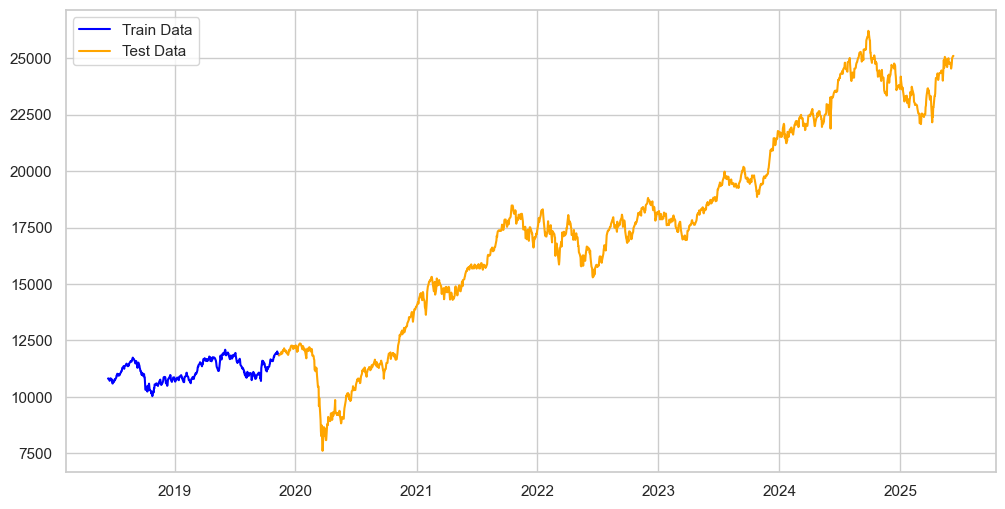

In [245]:
X = nikkei_0['Diff'][1:]
y = nifty_0['Close'][1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, shuffle=False) #small train size

train_data = pd.DataFrame({'X': X_train, 'y': y_train})
test_data = pd.DataFrame({'X': X_test, 'y': y_test})

plt.figure(figsize=(12, 6))
plt.plot(train_data['y'], label='Train Data', color='blue')
plt.plot(test_data['y'], label='Test Data', color='orange')
plt.legend()

plt.grid(True)
plt.show()

We perform a test for the stationarity (ADF).

In [246]:
# STATIONARY TEST
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print("Non-stationary")
# print ADF test results for train and test data with f string
print(f"Train Data ADF Test:")
adf_test(train_data['y'])
print(f"\nNikkei Data ADF Test:")
adf_test(test_data['X'])

print(f"\nTest Data ADF Test after differencing:")
Y_prime = test_data['y'].diff().dropna()

adf_test(Y_prime)

Train Data ADF Test:
ADF Statistic: -1.846183
p-value: 0.357786
Non-stationary

Nikkei Data ADF Test:
ADF Statistic: -18.313696
p-value: 0.000000
Stationary

Test Data ADF Test after differencing:
ADF Statistic: -39.725878
p-value: 0.000000
Stationary


We check the cross-correlation between the differenced Nifty 50 series and the Nikkei exogenous variable.  
This helps us see if there is any lagged relationship between the two time series. 


Here we can observe a strong cross-correlation at lag 0, which can indicate that involving the Nikkei in our forecast could be judicious.

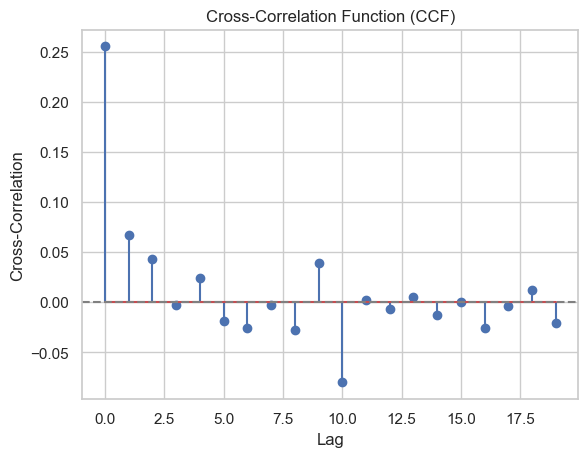

In [247]:
ccf_values = ccf(Y_prime, test_data['X'][1:])[:20]  
plt.stem(range(len(ccf_values)), ccf_values)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation Function (CCF)")
plt.show()

To confirm this observation, we perform a Granger causality test for different lags :

In [248]:
data = pd.DataFrame({"Y": test_data['y'], "X": test_data['X']})
grangercausalitytests(data, maxlag=3, verbose=False)

{1: ({'ssr_ftest': (6.682937248342201, 0.009830888024531442, 1450.0, 1),
   'ssr_chi2test': (6.69676401506291, 0.009658805578111098, 1),
   'lrtest': (6.681378837369266, 0.009742523362045218, 1),
   'params_ftest': (6.6829372483411795, 0.009830888024536558, 1450.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.740699217183698, 0.0012192832974337062, 1447.0, 2),
   'ssr_chi2test': (13.527982395785388, 0.0011546116816607995, 2),
   'lrtest': (13.465352401351993, 0.0011913404220701195, 2),
   'params_ftest': (6.740699217179219, 0.0012192832974391903, 1447.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.624373496714146, 0.0031730283555029813, 1444.0, 3),
   'ssr_chi2test': (13.940372459277478, 0.00298744984270825, 3),
   'lrtest': (13.873832767567364, 0.003082016331265168, 3),
   'params_ftest': (4.624373496714319, 0.0031730283555017917, 1444.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

We plot the PACF to indentify the order of the AR part :

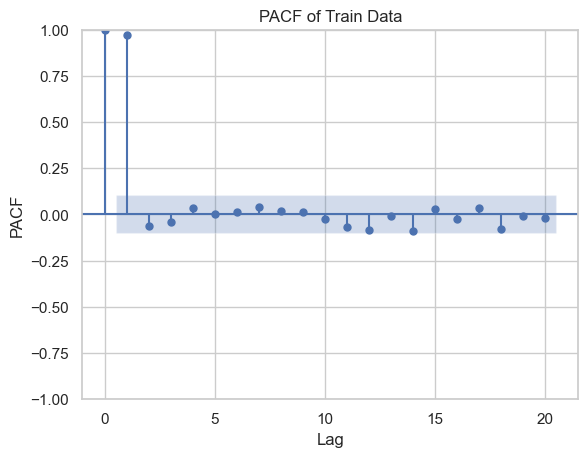

In [249]:
#PACF sur train
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['y'], lags=20)
plt.title("PACF of Train Data")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.grid(True)
plt.show()


## Forecasting

To select the initial models (with and without the exogenous variable), we use the $\texttt{pm.auto\_arima} $ function, which performs a grid search to automatically select the best parameters for our ARIMA (or ARIMAX) models by minimizing the AIC

In [250]:
y_train = np.array(train_data['y']).reshape(-1, 1)
X_train = np.array(train_data['X']).reshape(-1, 1)
model= pm.auto_arima(y_train ,X_train,seasonal=True, stepwise=True, suppress_warnings=True,trace=True) 
model2 = pm.auto_arima(y_train, seasonal=True, stepwise=True,suppress_warnings=True, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4343.945, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4340.796, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4342.123, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4342.174, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4339.108, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4344.654, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.124 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4343.552, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4344.978, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4345.021, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4341.864, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4346.931, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2167.554
Date:                Sun, 15 Jun 2025   AIC                           4339.108
Time:                        17:47:20   BIC                           4346.892
Sample:                             0   HQIC                          4342.203
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0497      0.024      2.034      0.042       0.002       0.098
sigma2      9298.0017    400.872     23.194      0.000    8512.307    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               257.52
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.68
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we can perform the two forecasts; the order of the models will be updated every 60 days.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2167.554
Date:                Sun, 15 Jun 2025   AIC                           4339.108
Time:                        17:50:43   BIC                           4346.892
Sample:                             0   HQIC                          4342.203
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0497      0.024      2.034      0.042       0.002       0.098
sigma2      9298.0017    400.872     23.194      0.000    8512.307    1.01e+04
Ljung-Box (L1) (Q):                   0.69   Jarque-

  0%|          | 0/1454 [00:00<?, ?it/s]

(2, 1, 2)


 33%|███▎      | 481/1454 [06:33<15:57,  1.02it/s] 

(0, 1, 1)


 41%|████▏     | 600/1454 [07:35<11:42,  1.22it/s]

(1, 0, 0)


 50%|████▉     | 720/1454 [09:47<05:42,  2.15it/s]

(0, 1, 1)


 54%|█████▎    | 780/1454 [10:04<02:24,  4.66it/s]

(1, 0, 0)


 62%|██████▏   | 900/1454 [13:21<13:29,  1.46s/it]

(2, 0, 0)


 70%|███████   | 1020/1454 [15:05<05:38,  1.28it/s]

(1, 0, 0)


 83%|████████▎ | 1200/1454 [18:03<02:38,  1.60it/s]

(1, 1, 0)


100%|██████████| 1454/1454 [21:31<00:00,  1.13it/s]


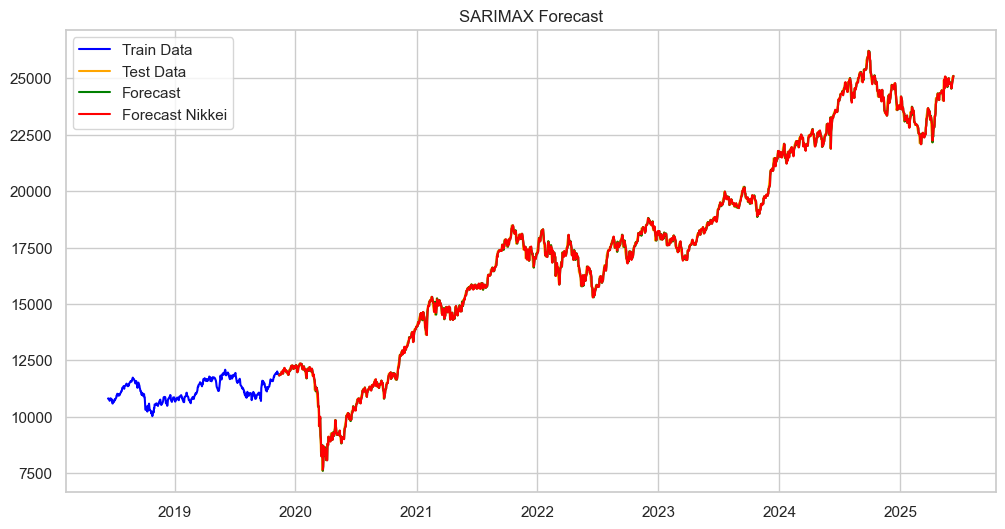

In [251]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from tqdm import tqdm
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

# beta est un dictionnaire qui va stocker les dates et les coefficients
beta = []
beta_time = []
exogenous= X_train.copy()
endogenous = y_train.copy()
order= (0, 1, 0)
order_nk = (0, 1, 0)
model_nik = SARIMAX(endogenous, exog=exogenous, order=order_nk, seasonal_order=(0, 0, 0, 0))
model = SARIMAX(endogenous, order=order, seasonal_order=(0, 0, 0, 0))
#model_nik =pm.auto_arima(endogenous, exog=exogenous, seasonal=True, stepwise=True, suppress_warnings=True)
#model = pm.auto_arima(endogenous, seasonal=True, stepwise=True, suppress_warnings=True)

forecast_nik = np.zeros((len(test_data)))
forecast = np.zeros((len(test_data)))
model_nik_fit = model_nik.fit(y=endogenous,exog=exogenous,disp=False)

beta.append(model_nik_fit.params[0])
beta_time.append(test_data.index[0])

model_fit = model.fit(y=endogenous,disp=False)
print(model_nik_fit.summary())
window=60

for i in tqdm(range(len(test_data))):
   

    y_pred_nik =model_nik_fit.forecast(steps=1, exog=X_test[i:i+1])
    y_pred = model_fit.forecast(steps=1)
    
    #y_pred_nik=model_nik_fit.predict(n_periods=1, exog=test_data['X'][i:i+1])
    #y_pred=model_fit.predict(n_periods=1)
    forecast_nik[i] = y_pred_nik
    forecast[i] = y_pred
    

    
    exogenous = np.append(exogenous, test_data['X'][i])
    endogenous = np.append(endogenous, test_data['y'][i])
    


    #model_nik =pm.auto_arima(endogenous[-75:], exog=exogenous[-75:], seasonal=True, stepwise=True, suppress_warnings=True)
    #model = pm.auto_arima(endogenous[-75:], seasonal=True, stepwise=True, suppress_warnings=True)
    if i % window == 0:
        recent_endog = endogenous[-window:]
        recent_exog = exogenous[-window:]
        model_nik=pm.auto_arima(recent_endog, exog=recent_exog, seasonal=False, stepwise=True, suppress_warnings=True)
        model=pm.auto_arima(recent_endog, seasonal=False, stepwise=True, suppress_warnings=True)
        order= model.get_params()['order']
        order_nk= model_nik.get_params()['order']
        if order != (0, 1, 0):
            print(order)
    if order==(2,0,0):
        model_nik = SARIMAX(endogenous, exog=exogenous, order=(0,1,0), seasonal_order=(0, 0, 0, 0))
        beta.append(model_nik_fit.params[0])
        beta_time.append(test_data.index[i])
        model = SARIMAX(endogenous, order=(0,1,0), seasonal_order=(0, 0, 0, 0))
    else:
        model_nik = SARIMAX(endogenous, exog=exogenous, order=order_nk, seasonal_order=(0, 0, 0, 0))
        beta.append(model_nik_fit.params[0])
        beta_time.append(test_data.index[i])
        model = SARIMAX(endogenous, order=order, seasonal_order=(0, 0, 0, 0))
    
    model_nik_fit = model_nik.fit(y=endogenous,exog=exogenous,disp=False)
    model_fit = model.fit(y=endogenous,disp=False) 
     

plt.figure(figsize=(12, 6))
plt.plot(train_data['y'], label='Train Data', color='blue')
plt.plot(test_data['y'], label='Test Data', color='orange')
plt.plot(test_data.index, forecast, label='Forecast', color='green')
plt.plot(test_data.index, forecast_nik, label='Forecast Nikkei', color='red')
plt.legend()
plt.title('SARIMAX Forecast')
plt.show()

And for the coefficient of the exogenous variable :

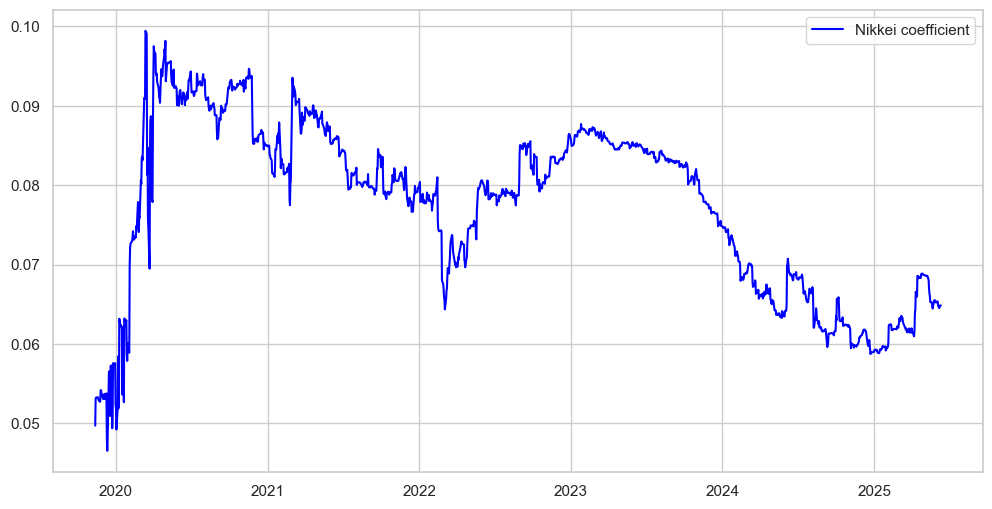

In [252]:
fig= plt.figure(figsize=(12, 6))
plt.plot(beta_time, beta, color='blue',label='Nikkei coefficient')
plt.legend()
plt.show()

In order to compare the two forecasts, we plotted the times when one model correctly predicts the direction while the other does not.

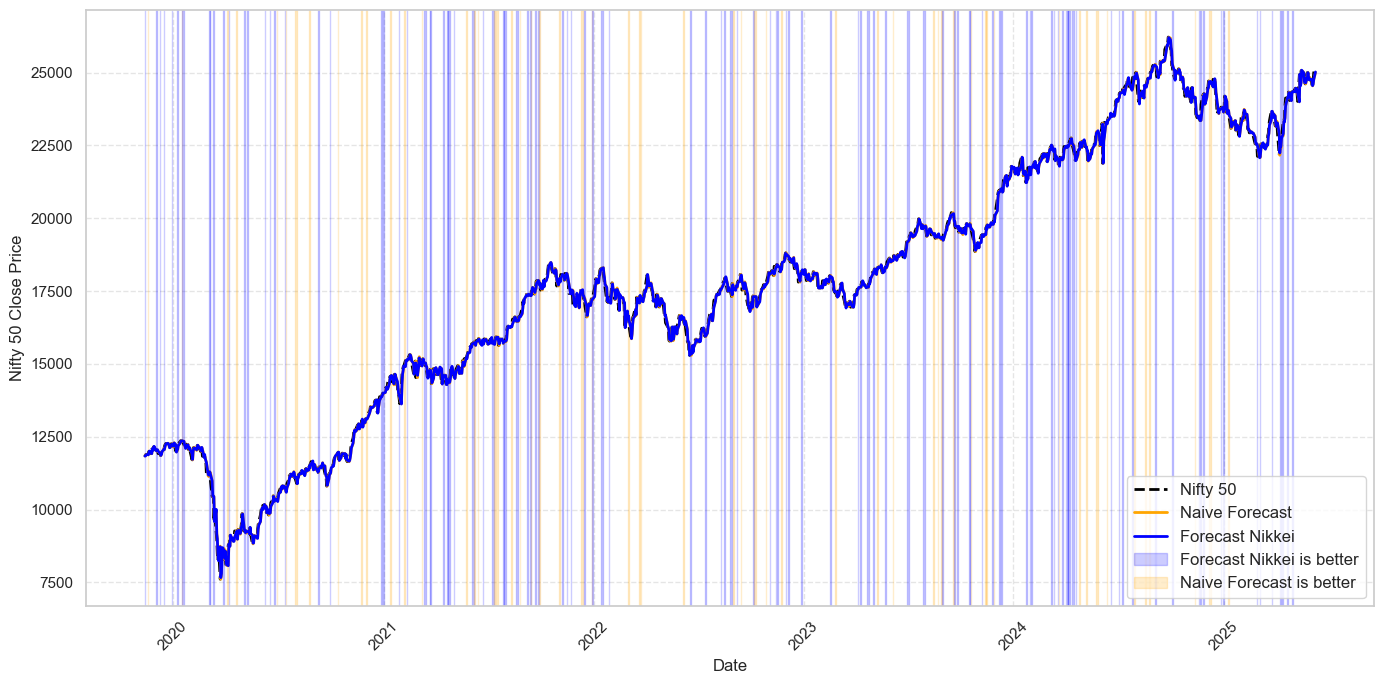

In [253]:
start, end = 0, len(test_data)-1
dates = test_data.index[start:end]
true_values = test_data['y'][start:end].values
forecast_slice = forecast[start:end]
forecast_nik_slice = forecast_nik[start:end]


plt.figure(figsize=(14, 7))
plt.plot(dates, true_values, label='Nifty 50', color='black', linestyle="--",linewidth=2)
plt.plot(dates, forecast_slice, label='Forecast', color="orange", linewidth=2)
plt.plot(dates, forecast_nik_slice, label='Forecast Nikkei', color='blue', linewidth=2)


for i in range(1, len(dates)):
    true_diff = true_values[i] - true_values[i - 1]
    forecast_diff = forecast_slice[i] - forecast_slice[i - 1]
    forecast_nik_diff = forecast_nik_slice[i] - forecast_nik_slice[i - 1]

    true_sign = np.sign(true_diff)
    forecast_sign = np.sign(forecast_diff)
    nikkei_sign = np.sign(forecast_nik_diff)

    if nikkei_sign == true_sign and forecast_sign != true_sign:
        plt.axvspan(dates[i - 1], dates[i], color='blue', alpha=0.2)
    elif forecast_sign == true_sign and nikkei_sign != true_sign:
        plt.axvspan(dates[i - 1], dates[i], color='orange', alpha=0.2)


blue_patch = mpatches.Patch(color='blue', alpha=0.2, label='Forecast Nikkei is better')
orange_patch = mpatches.Patch(color='orange', alpha=0.2, label='Naive Forecast is better')

plt.legend(handles=[
    plt.Line2D([], [], color='black',linestyle="--",linewidth=2, label='Nifty 50'),
    plt.Line2D([], [], color='orange', linewidth=2, label='Naive Forecast'),
    plt.Line2D([], [], color='blue', linewidth=2, label='Forecast Nikkei'),
    blue_patch,
    orange_patch
], fontsize=12)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Nifty 50 Close Price", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's zoom in on the specific period where the forecast with the Nikkei index outperformed the naive forecast.

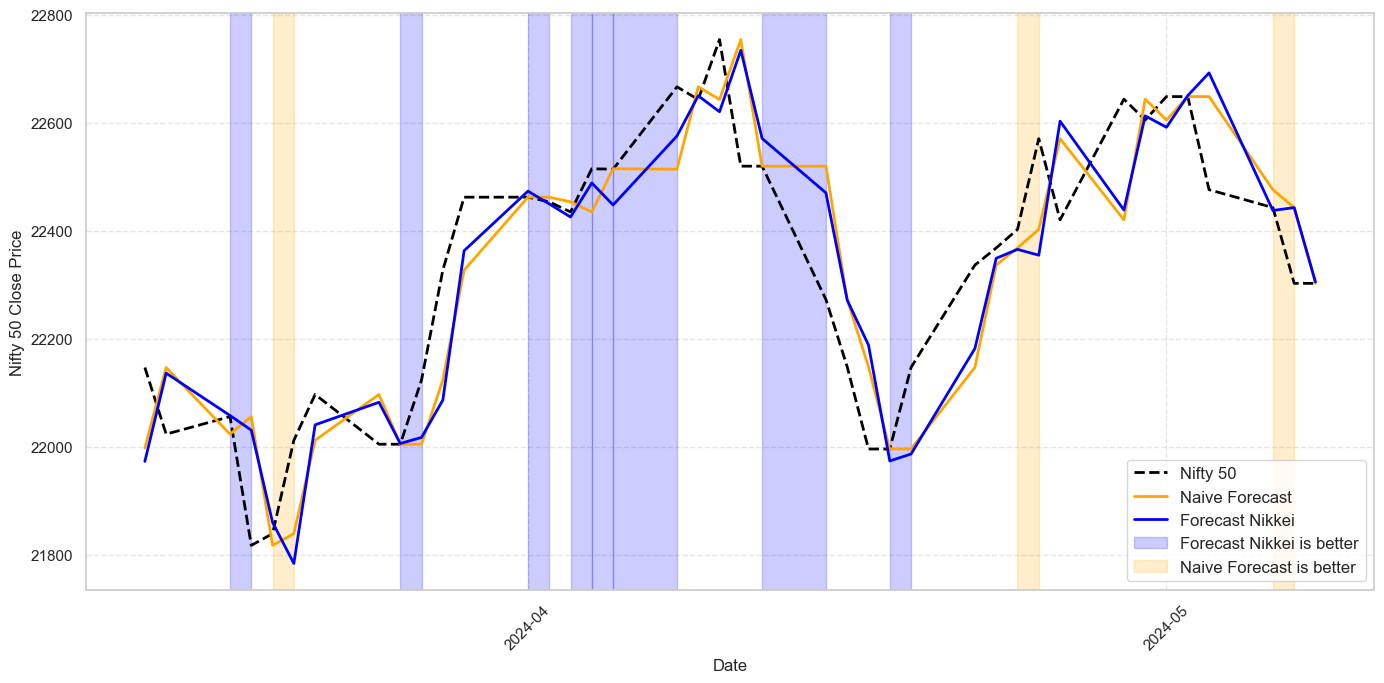

In [254]:
start, end = 1130, 1170
dates = test_data.index[start:end]
true_values = test_data['y'][start:end].values
forecast_slice = forecast[start:end]
forecast_nik_slice = forecast_nik[start:end]


plt.figure(figsize=(14, 7))
plt.plot(dates, true_values, label='Nifty 50', color='black', linestyle="--",linewidth=2)
plt.plot(dates, forecast_slice, label='Forecast', color="orange", linewidth=2)
plt.plot(dates, forecast_nik_slice, label='Forecast Nikkei', color='blue', linewidth=2)


for i in range(1, len(dates)):
    true_diff = true_values[i] - true_values[i - 1]
    forecast_diff = forecast_slice[i] - forecast_slice[i - 1]
    forecast_nik_diff = forecast_nik_slice[i] - forecast_nik_slice[i - 1]

    true_sign = np.sign(true_diff)
    forecast_sign = np.sign(forecast_diff)
    nikkei_sign = np.sign(forecast_nik_diff)

    if nikkei_sign == true_sign and forecast_sign != true_sign:
        plt.axvspan(dates[i - 1], dates[i], color='blue', alpha=0.2)
    elif forecast_sign == true_sign and nikkei_sign != true_sign:
        plt.axvspan(dates[i - 1], dates[i], color='orange', alpha=0.2)


blue_patch = mpatches.Patch(color='blue', alpha=0.2, label='Forecast Nikkei is better')
orange_patch = mpatches.Patch(color='orange', alpha=0.2, label='Naive Forecast is better')


plt.legend(handles=[
    plt.Line2D([], [], color='black',linestyle="--",linewidth=2, label='Nifty 50'),
    plt.Line2D([], [], color='orange', linewidth=2, label='Naive Forecast'),
    plt.Line2D([], [], color='blue', linewidth=2, label='Forecast Nikkei'),
    blue_patch,
    orange_patch
], fontsize=12)


plt.xlabel("Date", fontsize=12)
plt.ylabel("Nifty 50 Close Price", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


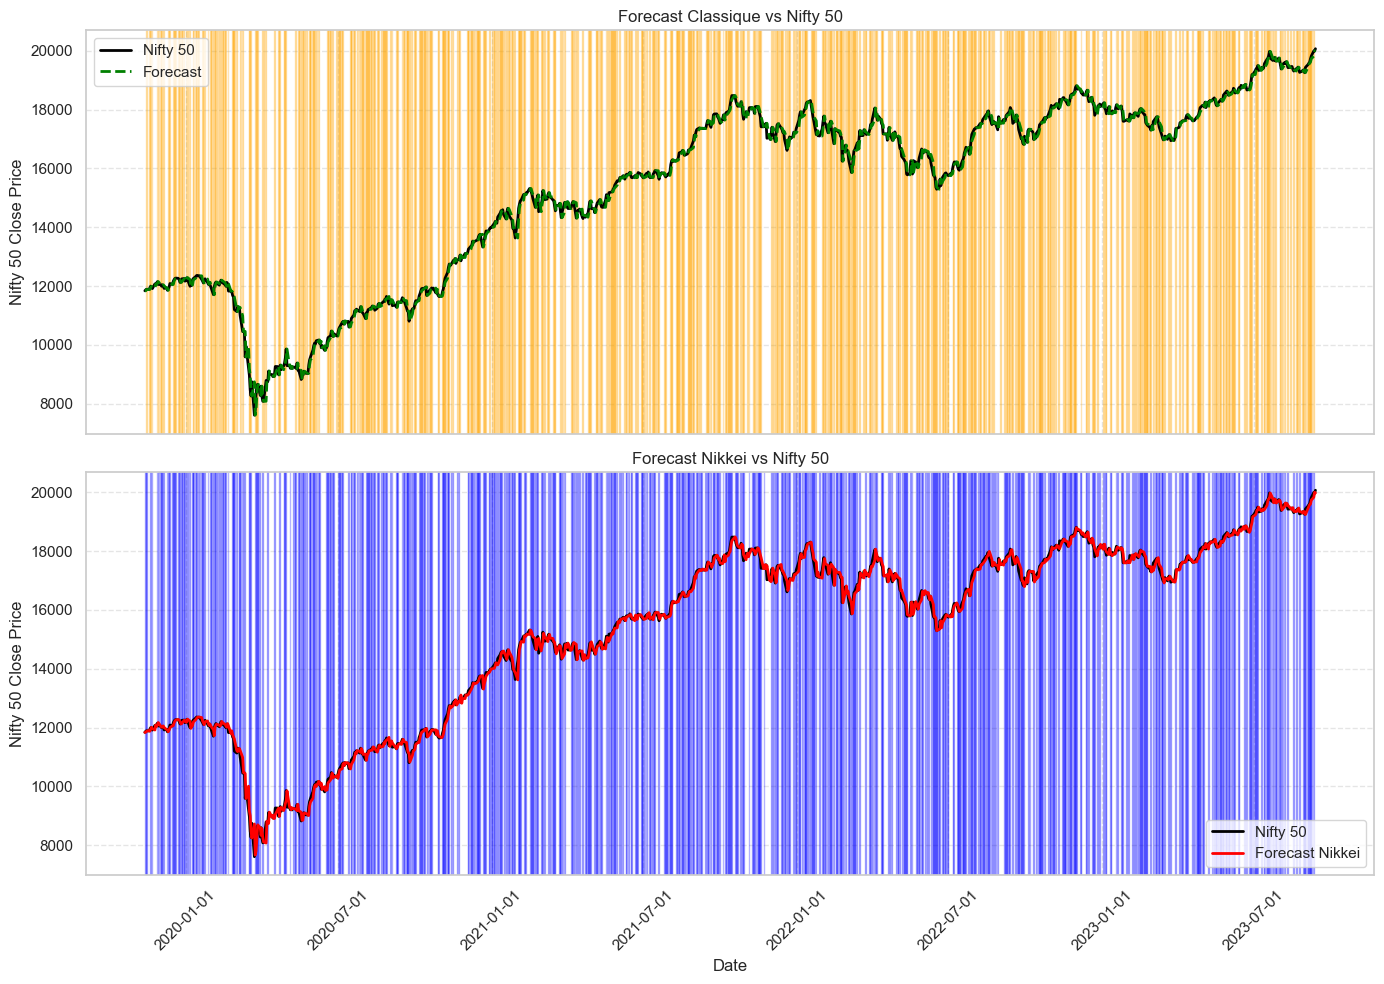

In [255]:
start, end = 0, 1000
dates = test_data.index[start:end]
true_values = test_data['y'][start:end].values
forecast_slice = forecast[start:end]
forecast_nik_slice = forecast_nik[start:end]


fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
count1= 0
count2= 0

axes[0].plot(dates, true_values, label='Nifty 50', color='black', linewidth=2)
axes[0].plot(dates, forecast_slice, label='Forecast', color='green', linestyle='--', linewidth=2)


axes[1].plot(dates, true_values, label='Nifty 50', color='black', linewidth=2)
axes[1].plot(dates, forecast_nik_slice, label='Forecast Nikkei', color='red', linewidth=2)


for i in range(1, len(dates)):
    true_diff = true_values[i] - true_values[i - 1]
    forecast_diff = forecast_slice[i] - forecast_slice[i - 1]
    forecast_nik_diff = forecast_nik_slice[i] - forecast_nik_slice[i - 1]

    true_sign = np.sign(true_diff)
    forecast_sign = np.sign(forecast_diff)
    nikkei_sign = np.sign(forecast_nik_diff)

   
    if forecast_sign == true_sign :
        axes[0].axvspan(dates[i - 1], dates[i], color='orange', alpha=0.3)
        count1 += 1
   
    if nikkei_sign == true_sign :
        axes[1].axvspan(dates[i - 1], dates[i], color='blue', alpha=0.3)
        count2 += 1

axes[0].set_title("Forecast Classique vs Nifty 50")
axes[1].set_title("Forecast Nikkei vs Nifty 50")
axes[1].set_xlabel("Date")
axes[0].set_ylabel("Nifty 50 Close Price")
axes[1].set_ylabel("Nifty 50 Close Price")

for ax in axes:
    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Now we can compute various metrics to confirm that the forecast incorporating the Nikkei is indeed better, as suggested by the previous graphs.

In [256]:
forecast=np.array(forecast).flatten() 

mae = mean_absolute_error(test_data['y'], forecast)
mse = mean_squared_error(test_data['y'], forecast)
mae_nik = mean_absolute_error(test_data['y'], forecast_nik)
mse_nik = mean_squared_error(test_data['y'], forecast_nik)


CDC = 0
for i in range(1, len(test_data)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast[i] - forecast[i - 1]) > 0:
        CDC += 1

CDC_nik = 0
for i in range(1, len(test_data)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast_nik[i] - forecast_nik[i - 1]) > 0:
        CDC_nik += 1

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'CDC: {CDC / (len(test_data) - 1):.3f}') 
print(f'\nMAE Nikkei: {mae_nik:.2f}')
print(f'MSE Nikkei: {mse_nik:.2f}')
print(f'CDC Nikkei: {CDC_nik / (len(test_data) - 1):.3f}')

MAE: 119.03
MSE: 29535.21
CDC: 0.504

MAE Nikkei: 118.78
MSE Nikkei: 29111.73
CDC Nikkei: 0.540


## Trading Algorithm

In [257]:
def calculate_profit(test_data, forecast):
    """
    Calculate the profit from the trading strategy based on the forecasted values.
    Args:
        test_data (pd.DataFrame): DataFrame containing the test data with 'y' column for actual values.
        forecast (np.ndarray): Array of forecasted values.
    Returns:
       p1 (float): Final profit from the trading strategy based only on Long positions.
       p2 (float): Final profit from the trading strategy based on Long and Short positions.
       hold (float): Final profit from holding the index.
       profit1 (np.ndarray): Array of profits from the trading strategy based on Long positions.
       profit2 (np.ndarray): Array of profits from the trading strategy based on Long and Short positions.
       hold (np.ndarray): Array of profits from holding the index.
       desicion (np.ndarray): Array of decisions made (1 for buy, -1 for sell, 0 for risk-free investment).
    """
    profit = np.array([])
    capital_init = 1
    profit1 = np.append(profit, capital_init)
    profit2 = np.append(profit, capital_init)
   
    r=0.0433/252 # daily risk-free rate.
    desicion = np.array([])  # to store the decision to buy orsell (1 for buy, -1 for sell, 0 for risk-free investment)

    for i in range(1, len(test_data['y'])):
        if forecast[i] -forecast[i - 1]>r*forecast[i - 1]:  
            profit1 = np.append(profit1, profit1[i - 1] * test_data['y'].iloc[i] / test_data['y'].iloc[i - 1])
            profit2 = np.append(profit2, profit2[i - 1] * test_data['y'].iloc[i] / test_data['y'].iloc[i - 1])
            desicion = np.append(desicion, 1)  

        elif r*forecast[i-1] < forecast[i - 1]-forecast[i]: 
            profit1 = np.append(profit1, profit1[i - 1] * test_data['y'].iloc[i - 1] / test_data['y'].iloc[i])
            profit2 = np.append(profit2, profit2[i - 1])
            desicion = np.append(desicion, -1)  
        else:  
            profit1 = np.append(profit1, profit1[i - 1]*(1+r))
            profit2 = np.append(profit2, profit2[i - 1]*(1+r))
            desicion = np.append(desicion, 0)  

    profit1 = np.array(profit1)
    profit2 = np.array(profit2)
    hold=capital_init * np.array(test_data['y']) / test_data['y'].iloc[0]
    return(profit1[-1],profit2[-1], hold[-1],profit1, profit2, hold,desicion)

Given the trading algorithm above, we can evaluate this algorithm using the two forecasts we derived earlier, with a 6-month projection:

In [258]:
random.seed(42)
def random_day_profit(test_data, forecast, n_days=int(252/2)): #6 months projection
    
    random_day = random.randint(0, len(test_data) - n_days)
    
    test_data_period = test_data.iloc[random_day:random_day + n_days]
    forecast_period = forecast[random_day:random_day + n_days]
   
    profit1,profit2,hold,_,_,_,decision= calculate_profit(test_data_period, forecast_period)
    return profit1, profit2, hold, decision

profits1 = []
profits2 = []
profits1_nik = []
profits2_nik = []
holds = []

n_simulations = 10000 

for _ in range(n_simulations):
    profit1, profit2, hold,_= random_day_profit(test_data, forecast)
    profit1_nik, profit2_nik, _,_ = random_day_profit(test_data, forecast_nik)
    profits1.append(profit1)
    profits2.append(profit2)
    profits1_nik.append(profit1_nik)
    profits2_nik.append(profit2_nik)
    holds.append(hold)


In [259]:
df_profits = pd.DataFrame({'Profit with LONG and Short': profits1, 'Profit with LONG only': profits2,'Profit with nikkei long and short':profits1_nik,'Profit with nikkei long Only':profits2_nik,'Profit with HOLD': holds})

stats = df_profits.describe().T
stats['Better than Hold (%)'] = 0
for i in range(len(stats)):
    stats['Better than Hold (%)'][i] = len(df_profits[df_profits.iloc[:, i] > df_profits['Profit with HOLD']])/len(df_profits)

stats = stats.sort_values(by='mean', ascending=False)
stats

,count,mean,std,min,25%,50%,75%,max,Better than Hold (%)
Profit with nikkei long and short,10000.0,1.131219,0.112248,0.721542,1.065395,1.124985,1.199058,1.387783,0.6128
Profit with nikkei long Only,10000.0,1.102929,0.080784,0.838148,1.058255,1.103023,1.159752,1.300998,0.5617
Profit with LONG and Short,10000.0,1.102536,0.123697,0.760608,1.030758,1.103360,1.169400,1.419040,0.4754
Profit with LONG only,10000.0,1.087525,0.087041,0.795080,1.043794,1.094229,1.135936,1.281813,0.4900
Profit with HOLD,10000.0,1.084401,0.125192,0.730780,0.997396,1.090688,1.147522,1.503242,0.0000


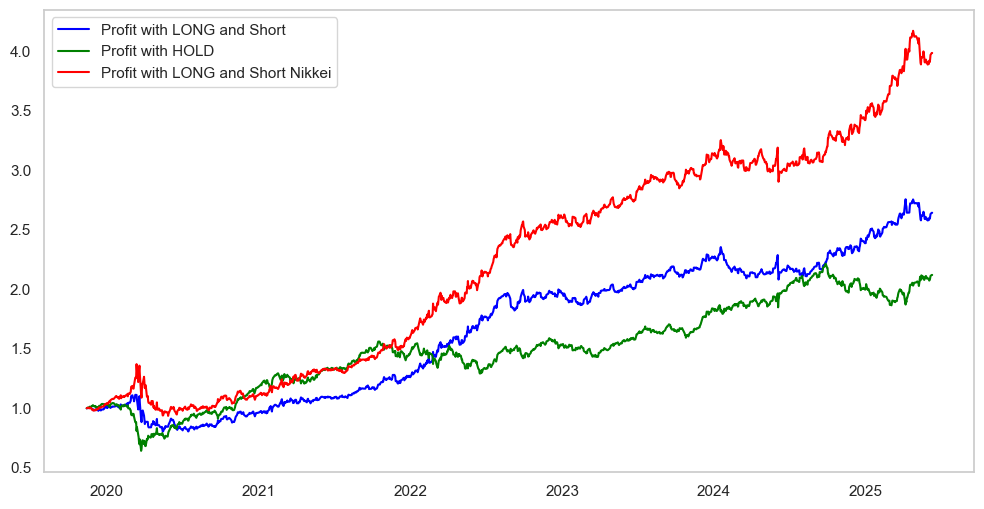

In [260]:
_,_,_,p1nk,p2nk,h,_=calculate_profit(test_data, forecast_nik)
_,_,_,p1,p2,_,_=calculate_profit(test_data, forecast)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, p1, label='Profit with LONG and Short' , color='blue' )
plt.plot(test_data.index, h, label='Profit with HOLD', color='green')
plt.plot(test_data.index, p1nk, label='Profit with LONG and Short Nikkei', color='red')
plt.legend()
plt.grid()
plt.show()

We can observe that we particularly outperformed the market during the COVID-19 crisis

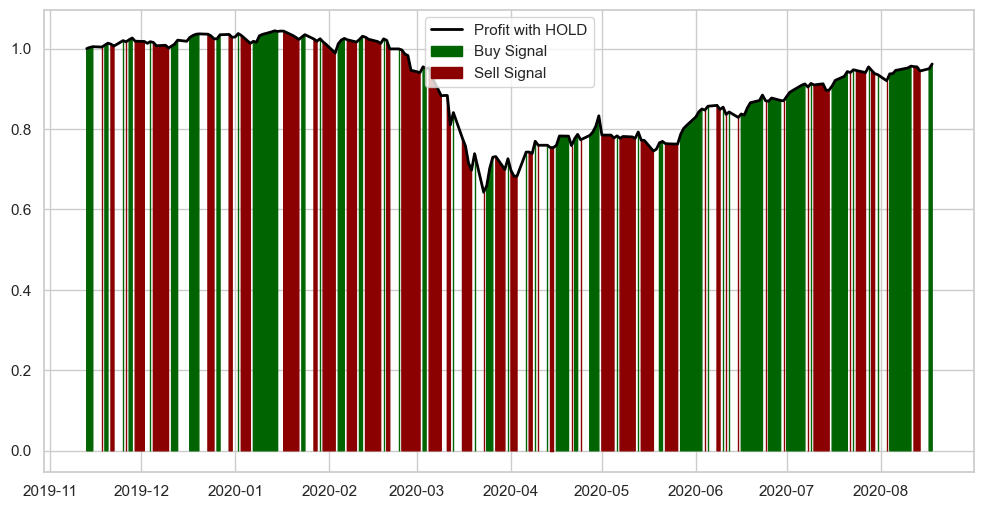

In [261]:

_,_,_,p1nk,p2nk,h,decision=calculate_profit(test_data, forecast_nik)
start,end= 0, 200
p1nk = p1nk[start:end]
p2nk = p2nk[start:end]
h = h[start:end]
p1 = p1[start:end]
p2 = p2[start:end]
decision = decision[start:end]


plt.figure(figsize=(12, 6))
plt.plot(test_data.index[start:end], h, label='Profit with HOLD', color='black', linewidth=2)
plt.fill_between(test_data.index[start:end], h, where=decision==1, color='darkgreen', alpha=1, label='Buy Signal')
plt.fill_between(test_data.index[start:end], h, where=decision==-1, color='darkred', alpha=1, label='Sell Signal')

plt.legend()
plt.show()

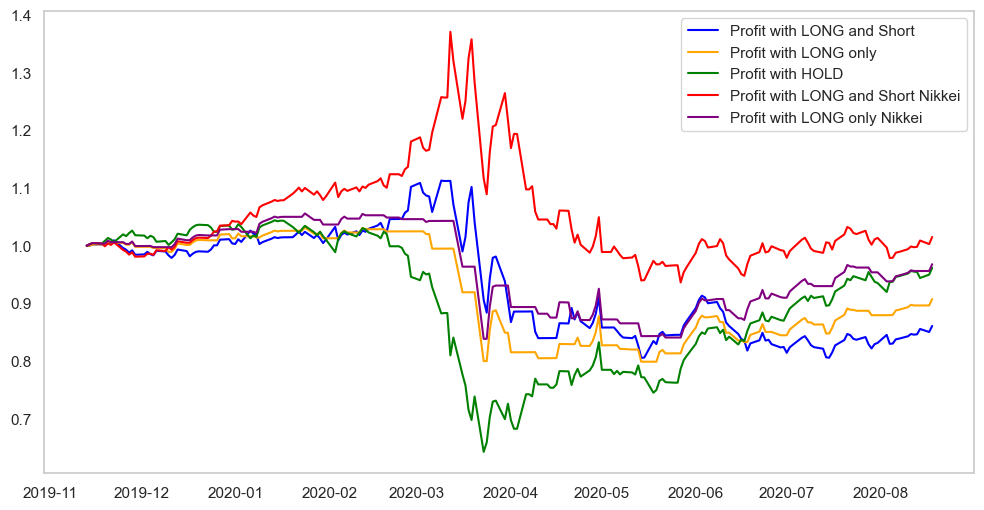

In [262]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:200], p1[:200], label='Profit with LONG and Short', color='blue')
plt.plot(test_data.index[:200], p2[:200], label='Profit with LONG only', color='orange')
plt.plot(test_data.index[:200], h[:200], label='Profit with HOLD', color='green')
plt.plot(test_data.index[:200], p1nk[:200], label='Profit with LONG and Short Nikkei', color='red')
plt.plot(test_data.index[:200], p2nk[:200], label='Profit with LONG only Nikkei', color='purple')
plt.legend()
plt.grid()
plt.show()

## Forecasting with VIX

After significantly improving the forecast by adding the Nikkei as an exogenous variable, we will now assess whether the VIX alone or combined with the Nikkei can further enhance forecasting performance.

### Granger Test - Can VIX improve forecasting ?

In [295]:
vix_nifty = vix_nifty_0['Open'] #We only have the open vix, we consider the open vix of the day is the close of yesterday
nifty = nifty_0['Close']

In [315]:
# === Step 1: Build the final dataset ===
Vol = pd.DataFrame({
    "Close": nifty,
    "VIX": vix_nifty,
})

Vol.dropna(inplace=True)

# === Step 2: Stationarity check (ADF test) ===
adf_test(Vol["VIX"])

ADF Statistic: -3.772202
p-value: 0.003205
Stationary


We see VIX is stationnary : we are able to use it as an exogeneous variable.

# Forecast with VIX & Nikkey

We now intuitively incorporate the VIX open of the day (treated as the previous day's close) as an exogenous variable to potentially enhance our forecast.

We will run two simulations :

One using only the VIX as an exogenous variable

One using both the VIX and the Nikkei as exogenous variables

The objective is to determine whether the VIX alone can improve the forecast, and whether it can further enhance the already strong performance achieved with the Nikkei.

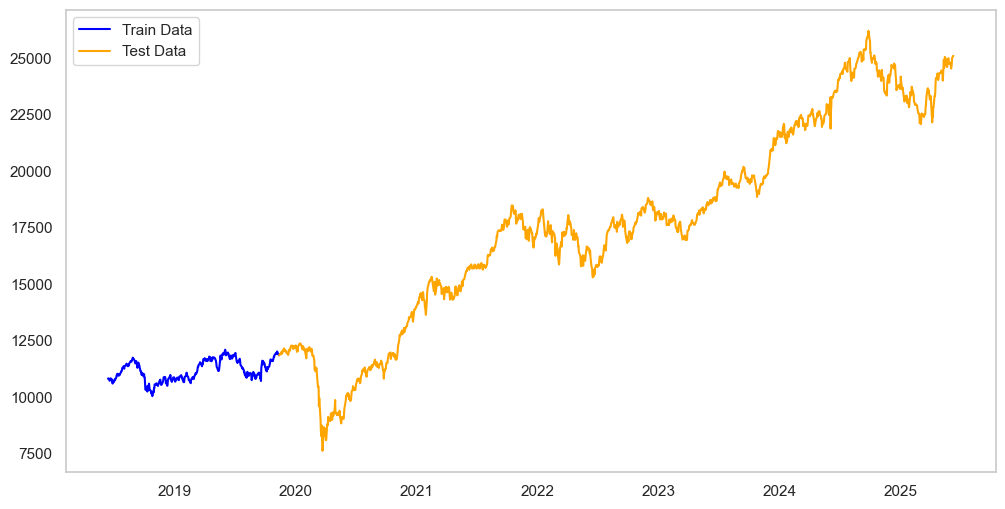

In [310]:
X = pd.DataFrame({'VIX': vix_nifty, 'Close_Diff':nikkei_0['Diff']})

X = X[1:]
y = nifty_0['Close'][1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, shuffle=False) 

train_data_vix_nik = X_train.copy()
train_data_vix_nik['y'] = y_train
test_data_vix_nik = X_test.copy()
test_data_vix_nik['y'] = y_test

plt.figure(figsize=(12, 6))
plt.plot(train_data_vix_nik['y'], label='Train Data', color='blue')
plt.plot(test_data_vix_nik['y'], label='Test Data', color='orange')
plt.legend()

plt.grid()
plt.show()

## Forecast with VIX, VIX + Nikkei, VIX shifted and VIX shifted + Nikkei

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  363
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2166.168
Date:                Sun, 15 Jun 2025   AIC                           4338.336
Time:                        21:21:36   BIC                           4350.011
Sample:                             0   HQIC                          4342.977
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VIX           -9.4174      5.090     -1.850      0.064     -19.395       0.560
Close_Diff     0.0497      0.024      2.047      0.041       0.002       0.097
sigma2      9226.9589    395.049     23.356      0.0

  0%|          | 0/1454 [00:00<?, ?it/s]

(2, 1, 2) (2, 1, 2)


 33%|███▎      | 481/1454 [06:18<19:59,  1.23s/it]

(0, 1, 1) (0, 1, 1)


 41%|████▏     | 600/1454 [07:24<10:12,  1.40it/s]

(1, 0, 0) (1, 0, 0)


 50%|████▉     | 720/1454 [10:04<09:31,  1.28it/s]

(0, 1, 1) (0, 1, 1)


 54%|█████▎    | 780/1454 [10:33<06:06,  1.84it/s]

(1, 0, 0) (1, 0, 0)


 62%|██████▏   | 900/1454 [13:29<09:41,  1.05s/it]

(2, 0, 0) (2, 0, 0)


 70%|███████   | 1020/1454 [15:57<10:00,  1.38s/it]

(1, 0, 0) (1, 0, 0)


 83%|████████▎ | 1200/1454 [20:46<06:30,  1.54s/it]

(1, 1, 0) (1, 1, 0)


100%|██████████| 1454/1454 [27:23<00:00,  1.13s/it]


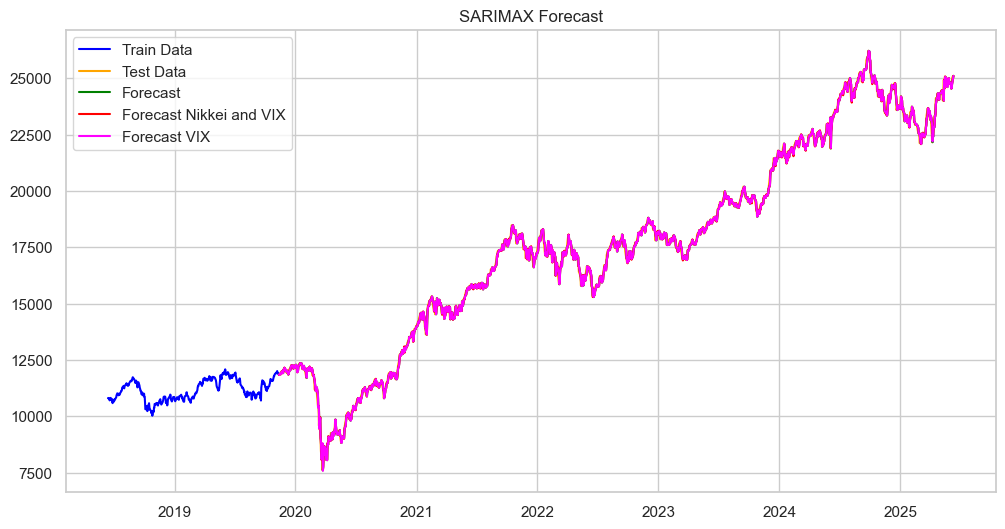

In [306]:
random.seed(42)

# Exogeneous variables
exog_columns_vix_nik = ['VIX','Close_Diff']
exog_columns_vix = ['VIX']


exogenous_vix_nik = X_train[exog_columns_vix_nik].copy()
exogenous_test_vix_nik = X_test[exog_columns_vix_nik].copy()

exogenous_vix = X_train[exog_columns_vix].copy()
exogenous_test_vix = X_test[exog_columns_vix].copy()

endogenous = y_train.copy()


# Initial Parameters
order_vix_nik = (0, 1, 0)
order_vix = (0, 1, 0)


# Initial Models

model_vix_nik = SARIMAX(endogenous, exog=exogenous_vix_nik, order=order_vix_nik, seasonal_order=(0, 0, 0, 0))

model_vix = SARIMAX(endogenous, exog=exogenous_vix, order=order_vix, seasonal_order=(0, 0, 0, 0))


# Empty Predictions

forecast_vix = np.zeros((len(test_data)))

forecast_vix_nik = np.zeros((len(test_data)))

# Initial fit

model_vix_nik_fit = model_vix_nik.fit(disp=False)

model_vix_fit = model_vix.fit(disp=False)

print(model_vix_nik_fit.summary())

# Window
window = 60

# Prediction Loop
for i in tqdm(range(len(test_data))):

    # Predictions


    y_pred_vix_nik = model_vix_nik_fit.forecast(steps=1, exog=exogenous_test_vix_nik.iloc[i:i+1,:])
    y_pred_vix = model_vix_fit.forecast(steps=1, exog=exogenous_test_vix.iloc[i:i+1,:])

    forecast_vix_nik[i] = y_pred_vix_nik
    forecast_vix[i] = y_pred_vix
    
    # Updating of data


    exogenous_vix_nik = pd.concat([exogenous_vix_nik, exogenous_test_vix_nik.iloc[i:i+1,:]])
    exogenous_vix = pd.concat([exogenous_vix, exogenous_test_vix.iloc[i:i+1,:]])
    
    endogenous = np.append(endogenous, test_data['y'].iloc[i])
  

    if i % window == 0:
        recent_endog = endogenous[-window:]
        recent_exog_vix_nik= exogenous_vix_nik[-window:]
        recent_exog_vix= exogenous_vix[-window:]
        model_vix_nik=pm.auto_arima(recent_endog, exog=recent_exog_vix_nik, seasonal=False, stepwise=True, suppress_warnings=True)
        model_vix=pm.auto_arima(recent_endog, exog=recent_exog_vix,seasonal=False, stepwise=True, suppress_warnings=True)
        order_vix= model_vix.get_params()['order']
        order_vix_nik= model_vix_nik.get_params()['order']
        if order_vix != (0, 1, 0) or order_vix_nik != (0, 1, 0):
            print(order_vix,order_vix_nik)
    # Security
    if order_vix == (2, 0, 0):
        order_vix = (0, 1, 0)
    if order_vix_nik == (2, 0, 0):
        order_vix_nik = (0, 1, 0)
    
    model_vix_nik = SARIMAX(endogenous, exog=exogenous_vix_nik, order=order_vix_nik, seasonal_order=(0, 0, 0, 0))
    model_vix = SARIMAX(endogenous,exog=exogenous_vix, order=order_vix, seasonal_order=(0, 0, 0, 0))
    
    model_vix_nik_fit = model_vix_nik.fit(y=endogenous,exog=exogenous_vix_nik,disp=False)
    model_vix_fit = model_vix.fit(y=endogenous,exog=exogenous_vix,disp=False) 
        

plt.figure(figsize=(12, 6))
plt.plot(train_data['y'], label='Train Data', color='blue')
plt.plot(test_data['y'], label='Test Data', color='orange')
plt.plot(test_data.index, forecast, label='Forecast', color='green')
plt.plot(test_data.index, forecast_vix_nik, label='Forecast Nikkei and VIX', color='red')
plt.plot(test_data.index, forecast_vix, label='Forecast VIX', color='magenta')
plt.legend()
plt.title('SARIMAX Forecast')
plt.show()

In [307]:
forecast=np.array(forecast).flatten() 

mae = mean_absolute_error(test_data['y'], forecast)
mse = mean_squared_error(test_data['y'], forecast)
mae_VIX = mean_absolute_error(test_data['y'], forecast_vix)
mse_VIX = mean_squared_error(test_data['y'], forecast_vix)
mae_nik = mean_absolute_error(test_data['y'], forecast_nik)
mse_nik = mean_squared_error(test_data['y'], forecast_nik)
mae_VIX_nik = mean_absolute_error(test_data['y'], forecast_vix_nik)
mse_VIX_nik = mean_squared_error(test_data['y'], forecast_vix_nik)


CDC = 0
for i in range(1, (len(test_data) - 1)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast[i] - forecast[i - 1]) > 0:
        CDC += 1

CDC_VIX = 0
for i in range(1,(len(test_data) - 1)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast_vix[i] - forecast_vix[i - 1]) > 0:
        CDC_VIX += 1


CDC_VIX_nik = 0
for i in range(1,(len(test_data) - 1)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast_vix_nik[i] - forecast_vix_nik[i - 1]) > 0:
        CDC_VIX_nik += 1

CDC_nik = 0
for i in range(1, (len(test_data) - 1)):
    if (test_data['y'].iloc[i] - test_data['y'].iloc[i - 1]) * (forecast_nik[i] - forecast_nik[i - 1]) > 0:
        CDC_nik += 1



print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'CDC: {CDC / (len(test_data) - 1):.3f}') 
print(f'\nMAE VIX: {mae_VIX:.2f}')
print(f'MSE VIX: {mse_VIX:.2f}')
print(f'CDC VIX: {CDC_VIX / (len(test_data) - 1):.3f}')
print(f'\nMAE Nikkei and VIX: {mae_VIX_nik:.2f}')
print(f'MSE Nikkei and VIX: {mse_VIX_nik:.2f}')
print(f'CDC Nikkei and VIX: {CDC_VIX_nik / (len(test_data) - 1):.3f}')
print(f'\nMAE Nikkei: {mae_nik:.2f}')
print(f'MSE Nikkei: {mse_nik:.2f}')
print(f'CDC Nikkei: {CDC_nik / (len(test_data) - 1):.3f}')

MAE: 119.03
MSE: 29535.21
CDC: 0.504

MAE VIX: 119.16
MSE VIX: 29756.25
CDC VIX: 0.519

MAE Nikkei and VIX: 118.81
MSE Nikkei and VIX: 29346.05
CDC Nikkei and VIX: 0.538

MAE Nikkei: 118.78
MSE Nikkei: 29111.73
CDC Nikkei: 0.540


We observe that the VIX alone is already capable of improving the forecast. However, when combined with the Nikkei, the performance is slightly lower than when using the Nikkei alone (53.8% vs. 54%).

We conclude this forecasting section by noting that while the VIX can enhance the model, the Nikkei alone remains the most effective exogenous variable in this project.

## Trading Algortihmic - VIX & Nikkei

In [308]:
def calculate_profit(test_data, forecast):
    """
    Calculate the profit from the trading strategy based on the forecasted values.
    Args:
        test_data (pd.DataFrame): DataFrame containing the test data with 'y' column for actual values.
        forecast (np.ndarray): Array of forecasted values.
    Returns:
       p1 (float): Final profit from the trading strategy based only on Long positions.
       p2 (float): Final profit from the trading strategy based on Long and Short positions.
       hold (float): Final profit from holding the index.
       profit1 (np.ndarray): Array of profits from the trading strategy based on Long positions.
       profit2 (np.ndarray): Array of profits from the trading strategy based on Long and Short positions.
       hold (np.ndarray): Array of profits from holding the index.
       desicion (np.ndarray): Array of decisions made (1 for buy, -1 for sell, 0 for risk-free investment).
    """
    profit = np.array([])
    capital_init = 1
    profit1 = np.append(profit, capital_init)
    profit2 = np.append(profit, capital_init)
   
    r=0.0433/252 # daily risk-free rate.
    desicion = np.array([])  # to store the decision to buy orsell (1 for buy, -1 for sell, 0 for risk-free investment)

    for i in range(1, len(test_data['y'])):
        if forecast[i] -forecast[i - 1]>r*forecast[i - 1]:  
            profit1 = np.append(profit1, profit1[i - 1] * test_data['y'].iloc[i] / test_data['y'].iloc[i - 1])
            profit2 = np.append(profit2, profit2[i - 1] * test_data['y'].iloc[i] / test_data['y'].iloc[i - 1])
            desicion = np.append(desicion, 1)  

        elif r*forecast[i-1] < forecast[i - 1]-forecast[i]: 
            profit1 = np.append(profit1, profit1[i - 1] * test_data['y'].iloc[i - 1] / test_data['y'].iloc[i])
            profit2 = np.append(profit2, profit2[i - 1])
            desicion = np.append(desicion, -1)  
        else:  
            profit1 = np.append(profit1, profit1[i - 1]*(1+r))
            profit2 = np.append(profit2, profit2[i - 1]*(1+r))
            desicion = np.append(desicion, 0)  

    profit1 = np.array(profit1)
    profit2 = np.array(profit2)
    hold=capital_init * np.array(test_data['y']) / test_data['y'].iloc[0]
    return(profit1[-1],profit2[-1], hold[-1],profit1, profit2, hold,desicion)

In [309]:
random.seed(42)
def random_day_profit(test_data, forecast, n_days=int(252/2)): #6 months projection
    
    random_day = random.randint(0, len(test_data) - n_days)
    
    test_data_period = test_data.iloc[random_day:random_day + n_days]
    forecast_period = forecast[random_day:random_day + n_days]
   
    profit1,profit2,hold,_,_,_,decision= calculate_profit(test_data_period, forecast_period)
    return profit1, profit2, hold, decision

profits1 = []
profits2 = []
profits1_nik = []
profits2_nik = []
profits1_vix = []
profits2_vix= []
profits1_vix_nik = []
profits2_vix_nik = []
holds = []

n_simulations = 10000 

for _ in range(n_simulations):
    profit1, profit2, hold,_= random_day_profit(test_data, forecast)
    profit1_nik, profit2_nik, _,_ = random_day_profit(test_data, forecast_nik)
    profit1_vix, profit2_vix, _,_ = random_day_profit(test_data, forecast_vix)
    profit1_vix_nik, profit2_vix_nik, _,_ = random_day_profit(test_data, forecast_vix_nik)
    profits1.append(profit1)
    profits2.append(profit2)
    profits1_nik.append(profit1_nik)
    profits2_nik.append(profit2_nik)
    profits1_vix.append(profit1_vix)
    profits2_vix.append(profit2_vix)
    profits1_vix_nik.append(profit1_vix_nik)
    profits2_vix_nik.append(profit2_vix_nik)
    holds.append(hold)


In [311]:
df_profits = pd.DataFrame({
    'Profit with VIX Long and Short': profits1_vix,
    'Profit with VIX Long only': profits2_vix,
    'Profit with Nikkei and VIX Long and Short': profits1_vix_nik,
    'Profit with  Nikkei and VIX Long only': profits2_vix_nik,
    'Profit with LONG and Short': profits1,
    'Profit with LONG only': profits2,
    'Profit with nikkei long and short': profits1_nik,
    'Profit with nikkei long Only': profits2_nik,
    'Profit with HOLD': holds
})

stats = df_profits.describe().T
stats['Better than Hold (%)'] = 0
for i in range(len(stats)):
    stats['Better than Hold (%)'][i] = len(df_profits[df_profits.iloc[:, i] > df_profits['Profit with HOLD']])/len(df_profits)

stats = stats.sort_values(by='mean', ascending=False)
stats

,count,mean,std,min,25%,50%,75%,max,Better than Hold (%)
Profit with Nikkei and VIX Long and Short,10000.0,1.133797,0.108788,0.733368,1.061990,1.123686,1.201488,1.387783,0.6155
Profit with nikkei long and short,10000.0,1.129949,0.113902,0.721542,1.064058,1.123964,1.201100,1.387783,0.6108
Profit with Nikkei and VIX Long only,10000.0,1.104059,0.077061,0.865262,1.056678,1.104896,1.160676,1.296640,0.5619
Profit with LONG and Short,10000.0,1.101535,0.123943,0.760608,1.029460,1.103082,1.168625,1.419040,0.4711
Profit with nikkei long Only,10000.0,1.101119,0.081261,0.838148,1.056958,1.101540,1.158353,1.300998,0.5592
Profit with VIX Long and Short,10000.0,1.097280,0.139059,0.667643,1.029426,1.097137,1.162691,1.459185,0.5445
Profit with LONG only,10000.0,1.087105,0.088098,0.795080,1.044932,1.095024,1.136034,1.281813,0.4891
Profit with VIX Long only,10000.0,1.086581,0.093050,0.779515,1.039545,1.093324,1.140683,1.281813,0.5273
Profit with HOLD,10000.0,1.084088,0.125114,0.730780,0.997255,1.091523,1.147503,1.503242,0.0000


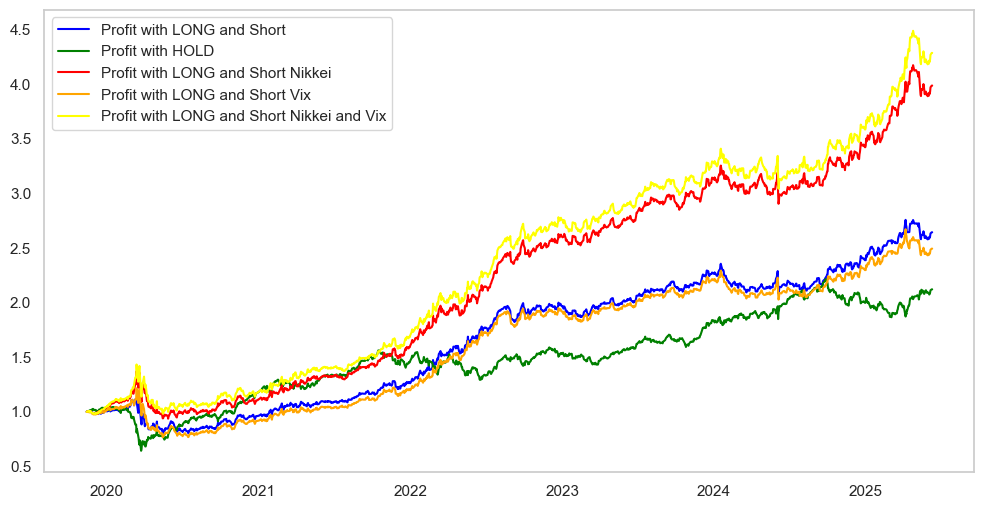

In [312]:
_,_,_,p1nk,p2nk,h,_=calculate_profit(test_data, forecast_nik)
_,_,_,p1,p2,_,_=calculate_profit(test_data, forecast)
_,_,_,p1_rv,p2_rv,_,_=calculate_profit(test_data, forecast_vix)
_,_,_,p1_vix,p2_vix,_,_=calculate_profit(test_data, forecast_vix)
_,_,_,p1_rv_nik,p2_rv_nik,_,_=calculate_profit(test_data, forecast_vix_nik)
_,_,_,p1_vix_nik,p2_vix_nik,_,_=calculate_profit(test_data, forecast_vix_nik)
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, p1, label='Profit with LONG and Short' , color='blue' )
plt.plot(test_data.index, h, label='Profit with HOLD', color='green')
plt.plot(test_data.index, p1nk, label='Profit with LONG and Short Nikkei', color='red')
plt.plot(test_data.index, p1_vix, label='Profit with LONG and Short Vix', color='orange')
plt.plot(test_data.index, p1_vix_nik, label='Profit with LONG and Short Nikkei and Vix', color='yellow')
plt.legend()
plt.grid()
plt.show()

Interestingly, we observe that the combination of the Nikkei and the VIX generates higher profits than using the Nikkei alone. However, we cannot conclude that this first method is superior, as doing so would introduce hindsight bias. Despite the higher profits, the second approach may still be more robust it's possible that the improved performance of the first was simply due to chance over this specific time period.

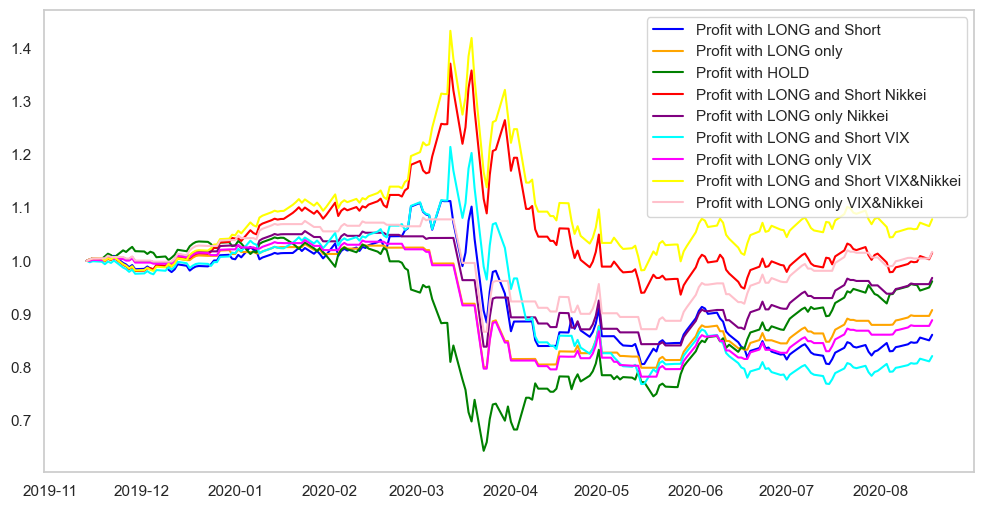

In [313]:
plt.figure(figsize=(12, 6))

plt.plot(test_data.index[:200], p1[:200], label='Profit with LONG and Short', color='blue')
plt.plot(test_data.index[:200], p2[:200], label='Profit with LONG only', color='orange')
plt.plot(test_data.index[:200], h[:200], label='Profit with HOLD', color='green')
plt.plot(test_data.index[:200], p1nk[:200], label='Profit with LONG and Short Nikkei', color='red')
plt.plot(test_data.index[:200], p2nk[:200], label='Profit with LONG only Nikkei', color='purple')
plt.plot(test_data.index[:200], p1_vix[:200], label='Profit with LONG and Short VIX', color='cyan')
plt.plot(test_data.index[:200], p2_vix[:200], label='Profit with LONG only VIX', color='magenta')
plt.plot(test_data.index[:200], p1_vix_nik[:200], label='Profit with LONG and Short VIX&Nikkei', color='yellow')
plt.plot(test_data.index[:200], p2_vix_nik[:200], label='Profit with LONG only VIX&Nikkei', color='pink')
plt.legend()
plt.grid()
plt.show()

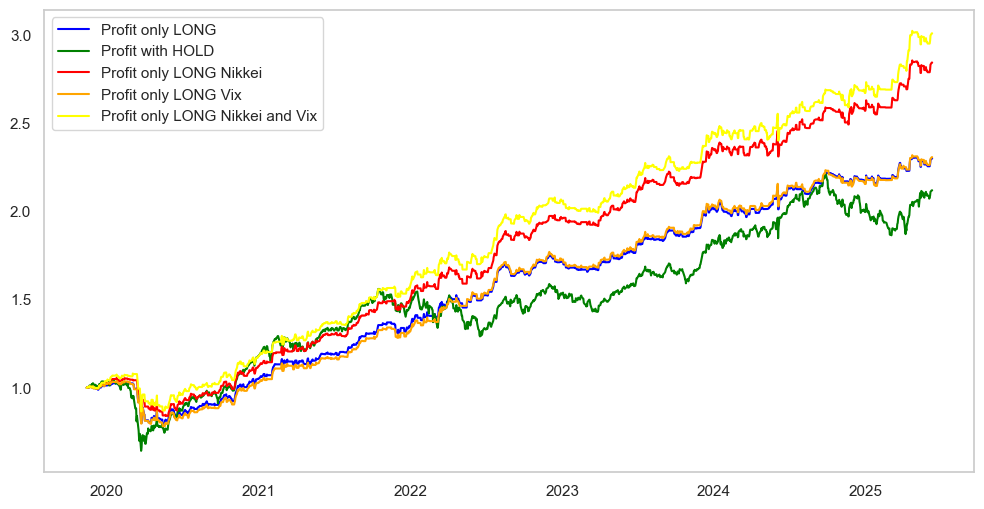

In [314]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, p2, label='Profit only LONG' , color='blue' )
plt.plot(test_data.index, h, label='Profit with HOLD', color='green')
plt.plot(test_data.index, p2nk, label='Profit only LONG Nikkei', color='red')
plt.plot(test_data.index, p2_vix, label='Profit only LONG Vix', color='orange')
plt.plot(test_data.index, p2_vix_nik, label='Profit only LONG Nikkei and Vix', color='yellow')
plt.legend()
plt.grid()
plt.show()